# Data import & Basic Inspection

In [2]:
import pandas as pd

In [3]:
# Load dataset
df = pd.read_csv("heart_2020_cleaned.csv")

# Basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


# Data Cleaning

In [4]:
# Convert Yes/No columns to 1/0
for col in df.columns:
    if df[col].dtype == 'object' and set(df[col].unique()) <= {'Yes','No'}:
        df[col] = df[col].map({'Yes':1, 'No':0})

# Check missing values
print(df.isnull().sum().sum(), "missing values in total")

# Confirm target column
target_col = 'HeartDisease'
df[target_col].value_counts()

0 missing values in total


HeartDisease
0    292422
1     27373
Name: count, dtype: int64

Cleaning Summary:

All binary “Yes/No” features were mapped to numeric values.

Dataset contains no missing values (if any, we would fill with median/mode).

The target label is HeartDisease.

# Exploratory Data Analysis (EDA)

HeartDisease      1.000000
DiffWalking       0.201258
Stroke            0.196835
PhysicalHealth    0.170721
KidneyDisease     0.145197
Smoking           0.107764
SkinCancer        0.093317
BMI               0.051803
Asthma            0.041444
MentalHealth      0.028591
Name: HeartDisease, dtype: float64


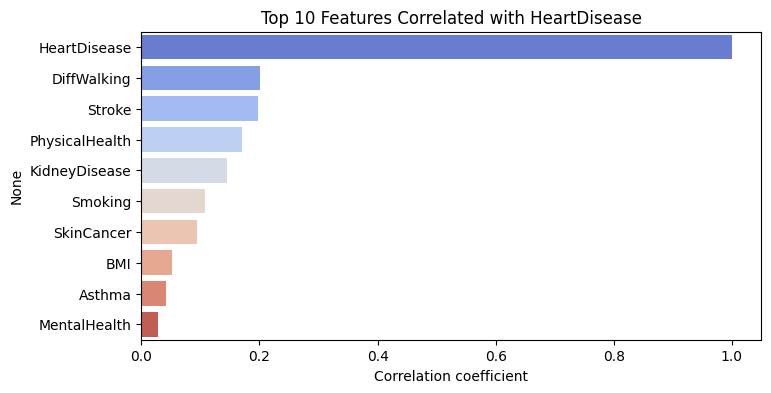

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = df.corr(numeric_only=True)
corr_target = corr["HeartDisease"].sort_values(ascending=False)

# Top correlated features
top_corr = corr_target.head(10)
print(top_corr)

# Visualize
plt.figure(figsize=(8,4))
sns.barplot(
    x=top_corr.values,
    y=top_corr.index,
    hue=top_corr.index,         
    palette="coolwarm",
    legend=False                
)
plt.title("Top 10 Features Correlated with HeartDisease")
plt.xlabel("Correlation coefficient")
plt.show()


Features like DiffWalking, Stroke, PhysicalHealth, and KidneyDisease show positive correlations with HeartDisease.

These suggest mobility challenges and chronic illnesses are significant predictors.

# Model Training & Evaluation
Train Logistic Regression and Random Forest, compare results using accuracy, precision, recall, and F1-score.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Separate target
X = df.drop(columns=[target_col])
y = df[target_col]

# One-hot encode categorical columns (Sex, Race, etc.)
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale only numeric columns
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes('number').columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Logistic Regression
log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)
y_pred_log = log.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate
def evaluate(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }

results = {
    "Logistic Regression": evaluate(y_test, y_pred_log),
    "Random Forest": evaluate(y_test, y_pred_rf)
}

pd.DataFrame(results).T


,accuracy,precision,recall,f1
Logistic Regression,0.916084,0.551302,0.105217,0.176709
Random Forest,0.904352,0.333056,0.117200,0.173387


Even though accuracy looks good, the model is not performing well at detecting heart disease cases.
Which likely means your dataset is imbalanced — too many “No Disease” vs “Disease” samples.